# Простой эксперимент

Этот эксперимент простой, потому что не берет во внимание саму структуру бота. Диалоги тут генерируются случайным нормальным распределением.

Здесь я генерирую визиты клиентов в бот с рекламы с заданной продолжительностью.
Поведение каждого клиента симулирую случайным количеством взаимодействий с ботом со случайными промежутками между взаимодействиями.

Так я накапливаю большой массив дат запросов за время работы рекламы.

Полученный массив разбиваю посекундно и считаю, сколько в каждую секунду было сделано запросов от всего объема клиентов.

Если предполагать, что бот отвечает на каждый запрос одним сообщением, то число этих запросов будет равно числу ответов бота.
Так можно оценить, какая будет нагрузка и предполагаемая задержка ответа ботом.

Например, если среднее число запросов в секунду в районе 30, то в среднем бот будет отвечать мгновенно, иногда через секунду, еще реже – через две секунды и т.д.

Но если в боте запрограммированы рассылки в фиксированное время суток, то в эти моменты пиковые нагрузки будут выше, чем оцениваемые в этом эксперименте.

## Вводные данные

In [21]:
import datetime as dt
import pytz

MSK = pytz.timezone('Europe/Moscow')

AD_START_TIME = dt.datetime(2021, 11, 10, 12, tzinfo=MSK)
AD_START_TIME.isoformat()

MIN_CLICKS_PER_HOUR = 800
MAX_CLICKS_PER_HOUR = 1200

AD_TOTAL_DAYS = 5
AD_ACTIVE_HOURS_PER_DAY = 24

MIN_STEPS = 2
MAX_STEPS = 50
MIN_SECONDS_BETWEEN_STEPS = 5.
MEAN_SECONDS_BETWEEN_STEPS = 60.
STD_SECONDS_BETWEEN_STEPS = 60. * 5


def print_inputs():
    print(
        f'Параметры эксперимента:\n\n'
        f'Старт рекламы: {AD_START_TIME}\n'
        f'Продолжительность рекламы: {AD_TOTAL_DAYS} дней\n'
        f'Реклама активна в течение каждого дня (в часах): {AD_ACTIVE_HOURS_PER_DAY}\n'
        f'Количество кликов по рекламе в час (минимум): {MIN_CLICKS_PER_HOUR}\n'
        f'Количество кликов по рекламе в час (максимум): {MAX_CLICKS_PER_HOUR}\n'
        f'Сколько шагов проходит каждый клиент (минимум): {MIN_STEPS}\n'
        f'Сколько шагов проходит каждый клиент (максимум): {MAX_STEPS}\n'
        f'Время между шагами (в секундах, среднее): {MEAN_SECONDS_BETWEEN_STEPS}\n'
        f'Время между шагами (в секундах, стандартное отклонение "шум"): {STD_SECONDS_BETWEEN_STEPS}\n'
    )

print_inputs()

Параметры эксперимента:

Старт рекламы: 2021-11-10 12:00:00+02:30
Продолжительность рекламы: 5 дней
Реклама активна в течение каждого дня (в часах): 24
Количество кликов по рекламе в час (минимум): 800
Количество кликов по рекламе в час (максимум): 1200
Сколько шагов проходит каждый клиент (минимум): 2
Сколько шагов проходит каждый клиент (максимум): 50
Время между шагами (в секундах, среднее): 60.0
Время между шагами (в секундах, стандартное отклонение "шум"): 300.0



### Симуляция

In [22]:
import pandas as pd
import random
import numpy as np

<AxesSubplot:title={'center':'Распределение времени между шагами (в секундах)'}, ylabel='Frequency'>

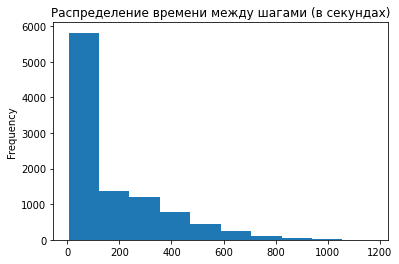

In [23]:
def generate_dialog_steps(count=MAX_STEPS):
    return [
        max(MIN_SECONDS_BETWEEN_STEPS, i) for i in
        np.random.normal(MEAN_SECONDS_BETWEEN_STEPS, STD_SECONDS_BETWEEN_STEPS, count)
    ]

pd.Series(generate_dialog_steps(10000)).plot(kind='hist', bins=10, title='Распределение времени между шагами (в секундах)')

In [24]:
requests = []
total_clients = 0
for day in range(AD_TOTAL_DAYS):
    for hour in range(AD_ACTIVE_HOURS_PER_DAY):
        clicks_in_this_hour = random.uniform(MIN_CLICKS_PER_HOUR, MAX_CLICKS_PER_HOUR)
        start_time = AD_START_TIME + dt.timedelta(days=day, hours=hour)
        for click_no in range(int(clicks_in_this_hour)):
            client_id = f'{day}:{hour}:{click_no}'
            total_clients += 1
            start_time = AD_START_TIME + dt.timedelta(days=day, hours=hour + random.uniform(0, 1))
            request_time = start_time
            steps_count = int(random.uniform(MIN_STEPS, MAX_STEPS))
            dialog_duration = 0
            for step in generate_dialog_steps(steps_count):
                requests.append({
                    'time': request_time,
                    'client': client_id,
                    'requests': 1,
                    'duration_seconds': dialog_duration,
                    'duration': dt.timedelta(seconds=dialog_duration),
                })
                dialog_duration += step
                request_time += dt.timedelta(seconds=step)
total_requests = len(requests)
f'Сгенерировано запросов: {total_requests}'

'Сгенерировано запросов: 3093474'

In [25]:
requests_df = pd.DataFrame.from_records(requests, index='time')

In [26]:
requests_df.head()

,client,requests,duration_seconds,duration
time,,,,
2021-11-10 12:35:55.052590+03:00,0:0:0,1,0.000000,0 days 00:00:00
2021-11-10 12:39:48.193942+03:00,0:0:0,1,233.141352,0 days 00:03:53.141352
2021-11-10 12:40:07.750392+03:00,0:0:0,1,252.697802,0 days 00:04:12.697802
2021-11-10 12:40:12.750392+03:00,0:0:0,1,257.697802,0 days 00:04:17.697802
2021-11-10 12:40:17.750392+03:00,0:0:0,1,262.697802,0 days 00:04:22.697802


### Результаты

In [31]:
print_inputs()

Параметры эксперимента:

Старт рекламы: 2021-11-10 12:00:00+02:30
Продолжительность рекламы: 5 дней
Реклама активна в течение каждого дня (в часах): 24
Количество кликов по рекламе в час (минимум): 800
Количество кликов по рекламе в час (максимум): 1200
Сколько шагов проходит каждый клиент (минимум): 2
Сколько шагов проходит каждый клиент (максимум): 50
Время между шагами (в секундах, среднее): 60.0
Время между шагами (в секундах, стандартное отклонение "шум"): 300.0



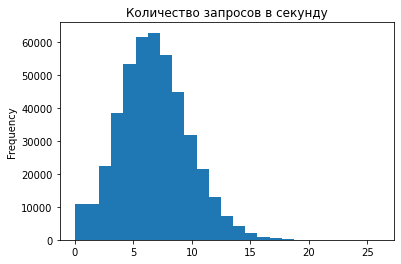

In [42]:
df = requests_df.copy()
df = df.requests
df.sort_index(inplace=True)
df = df.resample('S').sum()
df.plot(kind='hist', title='Количество запросов в секунду', bins=25)
rps_df = df  # requests per second

In [29]:
rps_max = rps_df.requests.max()
rps_min = rps_df.requests.min()
rps_mean = rps_df.requests.mean()

Статистика:

Запросов в секунду:
  Максимум: 26
  Минимум: 0
  В среднем: 6.99

Всего клиентов: 121221
Всего взаимодействий: 3093474



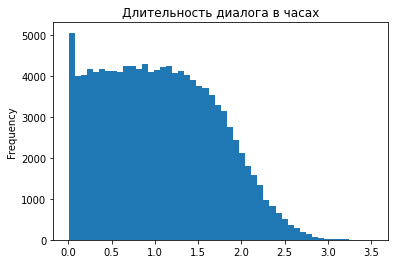

In [44]:
df = requests_df.copy()
df = df.reset_index().set_index('client')
df = df.groupby('client').duration_seconds.max() / 60 / 60
df.plot(kind='hist', bins=50, title='Длительность диалога в часах')
dialog_durations_df = df
dialog_duration_max = df.max()
dialog_duration_mean = df.mean()
dialog_duration_min = df.min()

In [50]:
def print_results():
    print(f'''Статистика:

    Запросов в секунду:
        Минимум: {rps_min}
        Максимум: {rps_max}
        В среднем: {rps_mean:.2f}

    Длительность диалога в часах:
        Минимум: {dialog_duration_min:.2f}
        Максимум: {dialog_duration_max:.2f}
        В среднем: {dialog_duration_mean:.2f}

    Всего клиентов: {total_clients}
    Всего взаимодействий: {total_requests}
''')

print_results()

Статистика:
    
    Запросов в секунду:
        Минимум: 0
        Максимум: 26
        В среднем: 6.99
    
    Длительность диалога в часах:
        Минимум: 0.00
        Максимум: 3.52
        В среднем: 1.05
    
    Всего клиентов: 121221
    Всего взаимодействий: 3093474



## Описание результатов

Простыми словами об эксперименте и полученных числах:

In [48]:
print(f'''В бот шел поток {MIN_CLICKS_PER_HOUR}-{MAX_CLICKS_PER_HOUR} лидов в час
на протяжении {AD_TOTAL_DAYS} рекламных дней по {AD_ACTIVE_HOURS_PER_DAY} часов каждый день.
Всего получено {total_clients} лидов.

Каждый лид получал от бота случайное количество сообщений (от {MIN_STEPS} до {MAX_STEPS}),
со случайными временными промежутками между ними (от {MIN_SECONDS_BETWEEN_STEPS} секунд, см. график Длительность диалога).

Такая симуляция произвела большой поток запросов от бота. Он менялся от {rps_min} до {rps_max} запросов в секунду.
В среднем держался {rps_mean:.2f} запросов в секунду.
''')

В бот шел поток 800-1200 лидов в час
на протяжении 5 рекламных дней по 24 часов каждый день.
Всего получено 121221 лидов.

Каждый лид получал от бота случайное количество сообщений (от 2 до 50),
со случайными временными промежутками между ними (от 5.0 секунд, см. график Длительность диалога).

Такая симуляция произвела большой поток запросов от бота. Он менялся от 0 до 26 запросов в секунду.
В среднем держался 6.99 запросов в секунду.



## Вывод

### Как использовать эти результаты?

Если ты ожидаешь от своей аудитории похожее взаимодействие с ботом:
(25 ± 20 сообщений с непредсказуемыми промежутками между ними) и
приводишь в бот около 1000 человек в час, то бот должен выдержать такую нагрузку и всегда отвечать мгновенно.

Кроме этого можно сделать уверенное предположение, что при суммарном повышении нагрузки в два раза
бот будет часто отвечать с задержкой в 1 секунду, иногда мгновенно. При повышении нагрузки до 10 раз,
средняя задержка ответа будет возрастать линейно, до 10 секунд.

Причем нагрузку можно изменять двумя способами: менять число лидов в час и изменять глубину среднего диалога.

Нагрузку более чем 10К человек в час при похожем сценарии диалога я не рекомендую давать.

Формула оценки средней задержки бота для похожих сценариев:

`LATENCY = DIALOG_SIZE * CPS / 25000`

где:
- `LATENCY` — оценка средней задержки ответа бота, в секундах
- `DIALOG_SIZE` — средняя длина диалога, в сообщениях
- `CPS` — CLICK PER SECOND — среднее количество переходов в бот, в кликах в секунду

### Что если взаимодействие с ботом будет несколько дней?

Такое может быть, если бот запрограммирован через день или более начинать взаимодействие снова,
например, отправив полезный пост или напоминание клиенту. Или если ты вручную просишь своих клиентов
вернуться в бот и выполнить действие. Или запускаешь ретаргетинг.

Это может увеличить нагрузку в середине рекламного периода, например на второй, третий день активного потока лидов в бот.
Потому что многие первые лиды еще продолжают взаимодействовать с ботом, а поток новых никуда не делся.

Дополнительную нагрузку в каждый такой день можно оценить отдельно и добавить в общую нагрузку:
- оценить, сколько клиентов продолжат взаимодействие после напоминания бота (`CPS_ADD`)
- оценить, какая у таких клиентов будет средняя длина диалога (`DIALOG_SIZE_ADD`)
- добавить эти новые параметры в формулу:
    `LATENCY = (DIALOG_SIZE * CPS + DIALOG_SIZE_ADD * CPS_ADD) / 25000`

Так ты получишь оценку задержки ответа бота в часы запланированного поста в середине рекламной кампании.
Это можно проделать для каждого дополнительного дня авто-воронки. Однако эти доп расчеты справедливы только, если
пост запланирован на выполнение через фиксированный период времени после какого-то этапа предыдущего дня,
например через 24 часа после начала диалога. Если пост запланирован на определенное время суток для всех
клиентов, то в это время суток нагрузка будет в десятки раз выше.

Например, рассчитаем дополнительную нагрузку к этому эксперименту:

Допустим, бот на следующий день начинает с клиентом новый диалог и в среднем такой диалог содержит 40 сообщений.
Предположим, что 50% лидов отсеялись на предыдущем дне и заблокировали бота. Тогда в течение следующего дня
общая нагрузка на бот будет равномерно увеличена. И средняя задержка в этот день будет примерно такая:

`LATENCY = (25 * 1000 + 40 * 500) / 25000 = 1.8` секунд.